In [48]:
#importation des libraries: 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Estimation et test du modèle à 5 facteurs de Fama French (2014)

En Asset Pricing, l'excès de rendement d'une action est décomposé de la façon suivante :

$$
R_{it}-RF_{t} = \alpha_{i} +\sum_{j=1}^{k} \beta_{i}^{j} f_{jt} + e_{it}
$$
où 
- $R_{it}$ est le rendement de l'action *i* à la date *t*,
- $RF_{t}$ est le taux sans risque à la date *t*,
- les $f_{it}, i=1,..,k$ sont *k* facteurs expliquant les variations communes des rendements et le risque non-diversifiable
- le $\beta_{i}^{j},j=1...,k$ est l'exposition de l'actif *i* au facteur $f_{jt}$
- $e_{it}$ est la composante spécifique à l'actif *i* représentant le risque diversifiable avec $E(e_{it})=0$

Si les facteurs sont correctement choisis, c'est-à-dire qu'ils représentent les variations des rendements anticipés, on aura $\alpha_{i}=0$ 

**Fama et French (1993)** (Common risk factors in the returns on stocks and bonds, Journal of Financial Economics, 33 (1) , pp. 3-56) proposent un modèle à trois facteurs afin d'analyser les rendements des actions ou des portefeuilles d'actions. 
Dans le modèle à 3 facteurs, le rendement moyen d'une action est supposé être corrélé avec :

1. le rendement du portefeuille du marché corrigé du taux sans risque : $Mkt-RF$
2. la taille (*Size*) de l'entreprise mesurée par sa capitalisation boursière (nombre d'actions en circulation $\times$ prix d'une action). 
    - Cet effet est mesuré par le facteur $SML_{t}$ égal à la différence de rendement d'un portefeuille de petites entreprises moins celui d'un portefeuille de grandes entreprises.
3. le book to market ratio *B/M* (ratio de la valeur comptable et de la valeur de marché). Une entreprise ayant un ratio B/M elevé sera plutôt sous-évaluée et on s'attend à ce qu'elle ait ura un taux de rendement élevé. 
    - Cet effet est mesuré par le facteur $HML_{t}$ calculé comme la difference de rendements entre des portefeuilles à haut (high)
et faible (Low) ratio B/M

Ces trois facteurs ne permettent pas d'expliquer totalement les variations des rendements anticipés.  **Fama et French (2015)** ('A five-factor asset pricing model', Journal of Financial Economics, 116 1-22) ajoutent deux facteurs supplémentaires prenant en compte : 

4. la profitabilité anticipée des entreprises : des gains anticipés plus élevés ont tendance à augmenter le taux de rendement (toutes choses égales par ailleurs). Le facteur $RMW_{t}$ est la différence de rendement entre un portefeuille d'entreprises à forte (robust) et faible (weak) rentabilité.
5. les investissements anticipés des entreprises : des investissements plus élevés ont tendance à réduire le taux de rendement (moins de dividendes donc une valeur de marché plus petite).  Le facteur $CMA_{t}$ est la différence entre un portefeuille d'entreprises à faible nivea d'investissement (conservative) et d'entreprises à fort niveau d'investissement (agressive)

L'objectif de cette fiche va être d'utiliser ces facteurs pour estimer la décomposition des rendements d'un ensemble de portefeuilles d'action du NYSE, AMEX et Nasdaq.
On vérifiera dans quelle mesure ces facteurs expliquent correctement les rendements anticipés

    
Les données se trouvent sur le site de Kenneth French
https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
    
    
**Dans les parties III et IV, les estimations devront être faites sur la période 1963-07-01 à 2023-07-01**


**Vous pouvez ajouter vos réponses (codes, affichage et commentaires des résultats) directement dans le notebook. Vous le sauvergarder avec votre nom.**
    


## I. Les 5 facteurs de Fama-French

#### 1. Importation des données 

Les données des facteurs de 5 facteurs de Fama-French sont stockées dans le fichier "F-F_Research_Data_5_Factors_2x3.csv". 

1. Importez les observations mensuelles de ces facteurs à partir de "1963-07-01".
2. Vérifiez l'existence de variables manquantes
3. Après des transformations appropriées, la date deviendra l'indice des données. 
4. Construire un dataframe spécifique pour le taux sans risque.

In [47]:

# Chemin du fichier CSV
file_path = 'F-F_Research_Data_5_Factors_2x3.csv'

# Importation des données en sautant les lignes d'en-tête inutiles
skip_rows = 3  # Ajustez ce nombre si nécessaire
ff_data = pd.read_csv(file_path, skiprows=skip_rows)

# Nettoyage des données : suppression des lignes non standard ou manquantes dans la colonne de date
ff_data_clean = ff_data.dropna(subset=['Unnamed: 0'])
ff_data_clean = ff_data_clean[ff_data_clean['Unnamed: 0'].apply(lambda x: x.isdigit())]

# Conversion de la colonne de date en format datetime et mise en place comme index
ff_data_clean['Date'] = pd.to_datetime(ff_data_clean['Unnamed: 0'], format='%Y%m')
ff_data_clean.set_index('Date', inplace=True)
ff_data_clean.drop(columns=['Unnamed: 0'], inplace=True)

# Conversion des colonnes de données en float
columns_to_convert = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
ff_data_clean[columns_to_convert] = ff_data_clean[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Création d'un DataFrame spécifique pour le taux sans risque (RF)
rf_data_clean = ff_data_clean[['RF']].copy()

# Affichage des premières lignes pour vérifier
print(ff_data_clean.tail())
print(rf_data_clean.head())


            Mkt-RF   SMB   HML   RMW   CMA    RF
Date                                            
2023-05-01    0.35 -0.38 -7.72 -1.81 -7.22  0.36
2023-06-01    6.46  1.34 -0.26  2.18 -1.62  0.40
2023-07-01    3.21  2.86  4.11 -0.57  0.57  0.45
2023-08-01   -2.39 -3.65 -1.06  3.43 -2.37  0.45
2023-09-01   -5.24 -1.79  1.52  1.87 -0.82  0.43
              RF
Date            
1963-07-01  0.27
1963-08-01  0.25
1963-09-01  0.27
1963-10-01  0.29
1963-11-01  0.27


#### 2. Vérification de l'existence de variables manquantes

Vérifiez l'existence de variables manquantes

#### 3. Formatage des dates + Taux sans risque

1. Transformez les dates en indice du dataframe
2. Stockez le taux sans risque RF dans un dataframe spécifique

#### 4. Représentation graphique des facteurs

Faites la représentation graphique des facteurs 

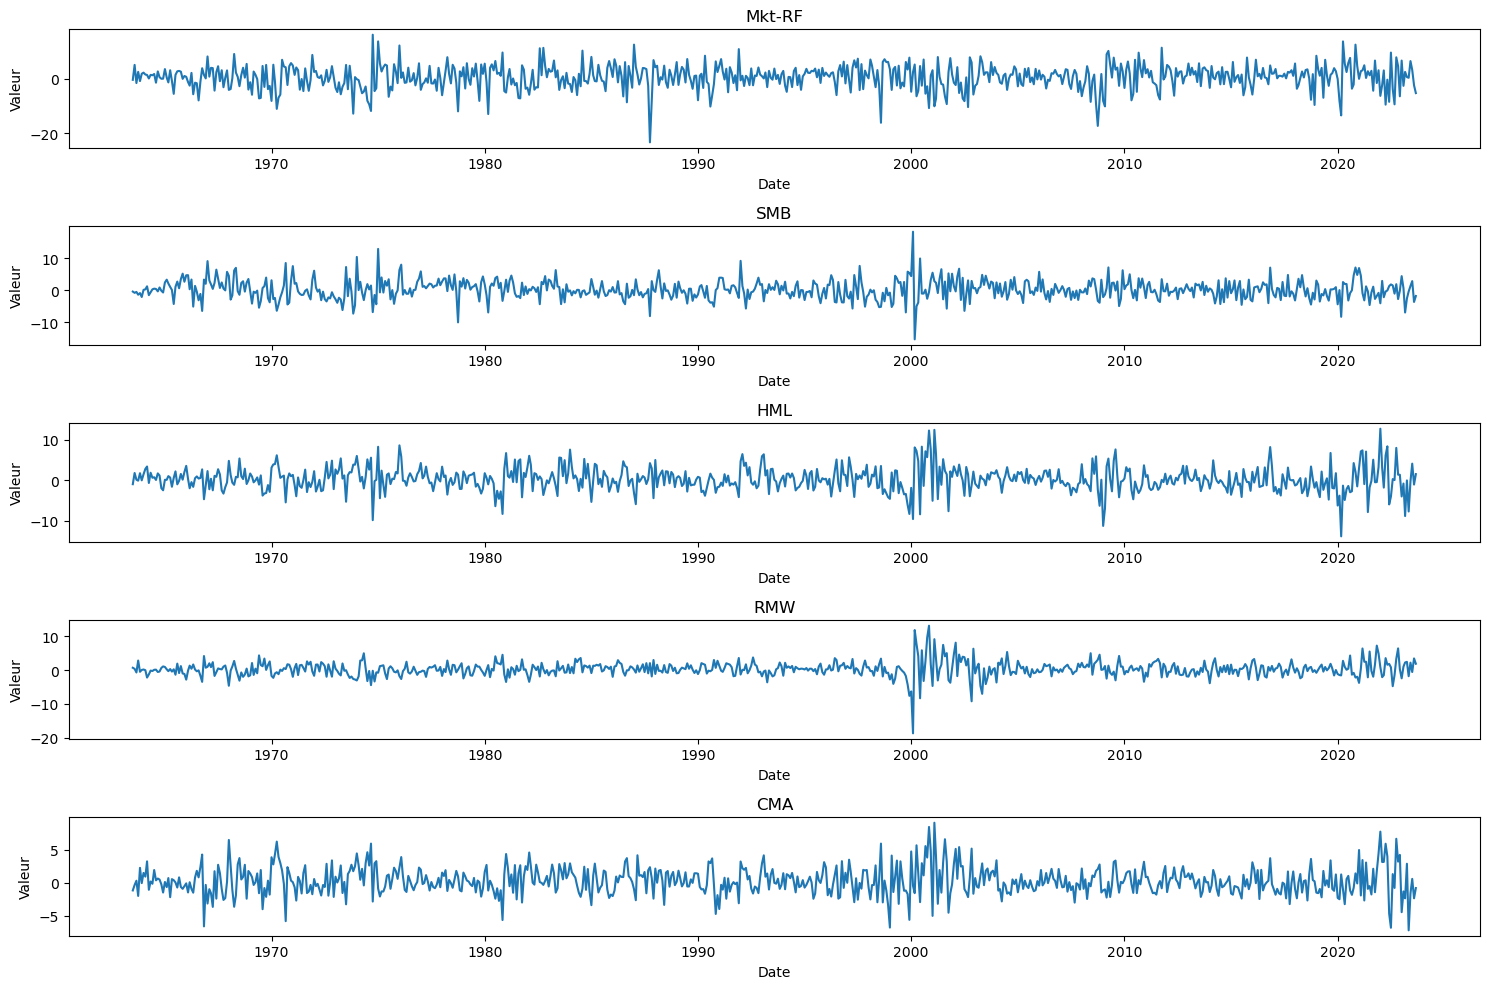

In [46]:
# Sélection des colonnes de facteur (à l'exception de 'RF')
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Création des graphiques pour chaque facteur
plt.figure(figsize=(15, 10))  # Ajustez la taille selon vos préférences

for i, factor in enumerate(factors):
    plt.subplot(len(factors), 1, i + 1)
    plt.plot(ff_data_clean.index, ff_data_clean[factor])
    plt.title(factor)
    plt.xlabel('Date')
    plt.ylabel('Valeur')

plt.tight_layout()
plt.show()


#### 5. Statistiques descriptives

Calculez la moyenne, le maximum, le minimum, l'écart-type, le skewness, le kurtosis pour chaque facteur

    - pour la totalité de l'échantillon
    - par année
    - par mois

In [45]:
# Calcul des statistiques descriptives pour la totalité de l'échantillon
desc_stats_total = pd.concat([
    ff_data_clean.describe(),
    pd.DataFrame({'skew': ff_data_clean.skew(), 'kurtosis': ff_data_clean.kurtosis()})
])

print("Statistiques descriptives pour la totalité de l'échantillon :")
print(desc_stats_total)

# Regroupement des données par année
grouped_data = ff_data_clean.groupby(ff_data_clean.index.year)

# Calcul des statistiques de base (mean, max, min, std) pour tous les facteurs ensemble par année
desc_stats_yearly_basic = grouped_data.agg(['mean', 'max', 'min', 'std'])

# Calcul de skew et kurtosis pour tous les facteurs ensemble par année
desc_stats_yearly_skew = grouped_data.apply(lambda x: pd.Series(x.values.flatten()).skew()).rename('skew')
desc_stats_yearly_kurtosis = grouped_data.apply(lambda x: pd.Series(x.values.flatten()).kurt()).rename('kurtosis')

# Combinaison des résultats dans un seul DataFrame
desc_stats_yearly = pd.concat([desc_stats_yearly_basic, desc_stats_yearly_skew, desc_stats_yearly_kurtosis], axis=1)

print("Statistiques descriptives pour tous les facteurs ensemble par année :")
print(desc_stats_yearly)

# Regroupement des données par mois
grouped_data_monthly = ff_data_clean.groupby(ff_data_clean.index.month)

# Calcul des statistiques de base (mean, max, min, std) pour tous les facteurs ensemble par mois
desc_stats_monthly_basic = grouped_data_monthly.agg(['mean', 'max', 'min', 'std'])

# Calcul de skew et kurtosis pour tous les facteurs ensemble par mois
desc_stats_monthly_skew = grouped_data_monthly.apply(lambda x: pd.Series(x.values.flatten()).skew()).rename('skew')
desc_stats_monthly_kurtosis = grouped_data_monthly.apply(lambda x: pd.Series(x.values.flatten()).kurt()).rename('kurtosis')

# Combinaison des résultats dans un seul DataFrame
desc_stats_monthly = pd.concat([desc_stats_monthly_basic, desc_stats_monthly_skew, desc_stats_monthly_kurtosis], axis=1)

print("Statistiques descriptives pour tous les facteurs ensemble par mois :")
print(desc_stats_monthly)



Statistiques descriptives pour la totalité de l'échantillon :
            Mkt-RF         SMB         HML         RMW         CMA  \
count   723.000000  723.000000  723.000000  723.000000  723.000000   
mean      0.555892    0.211189    0.283568    0.290650    0.274329   
std       4.491112    3.023388    2.995500    2.219599    2.080042   
min     -23.240000  -15.320000  -13.870000  -18.650000   -7.220000   
25%      -1.995000   -1.540000   -1.395000   -0.805000   -1.000000   
50%       0.910000    0.090000    0.220000    0.250000    0.090000   
75%       3.415000    2.015000    1.740000    1.310000    1.505000   
max      16.100000   18.280000   12.750000   13.070000    9.070000   
Mkt-RF         NaN         NaN         NaN         NaN         NaN   
SMB            NaN         NaN         NaN         NaN         NaN   
HML            NaN         NaN         NaN         NaN         NaN   
RMW            NaN         NaN         NaN         NaN         NaN   
CMA            NaN         N

#### 6. Matrice de correlation
1. Estimez la matrice de corrélation des facteurs et commentez
2. Faites une représentation graphique de cette matrice
3. Vérifiez la significativité de la corrélation entre les facteurs $HML$ et $SMB$

In [9]:
# Calcul de la matrice de corrélation
correlation_matrix = ff_data_clean.corr()

print("Matrice de corrélation des facteurs :")
print(correlation_matrix)

Matrice de corrélation des facteurs :
          Mkt-RF       SMB       HML       RMW       CMA        RF
Mkt-RF  1.000000  0.280470 -0.209185 -0.180923 -0.361115 -0.084629
SMB     0.280470  1.000000 -0.014685 -0.352044 -0.093437 -0.035583
HML    -0.209185 -0.014685  1.000000  0.088654  0.686378  0.066941
RMW    -0.180923 -0.352044  0.088654  1.000000 -0.012526 -0.009499
CMA    -0.361115 -0.093437  0.686378 -0.012526  1.000000  0.053965
RF     -0.084629 -0.035583  0.066941 -0.009499  0.053965  1.000000


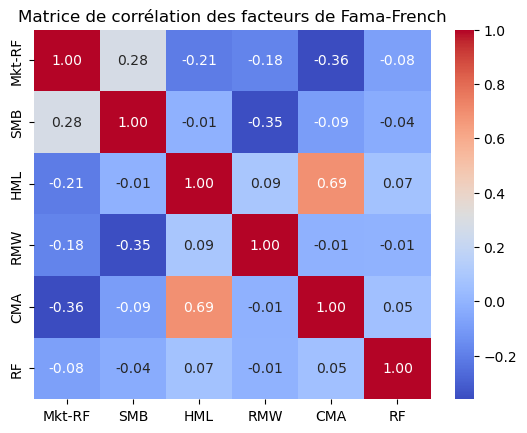

In [10]:
import seaborn as sns


# Représentation graphique de la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation des facteurs de Fama-French")
plt.show()

In [11]:
from scipy.stats import pearsonr

# Calcul de la corrélation et du p-value entre HML et SMB
corr_coefficient, p_value = pearsonr(ff_data_clean['HML'], ff_data_clean['SMB'])

print(f"Corrélation entre HML et SMB: {corr_coefficient:.2f}")
print(f"P-value: {p_value:.4f}")

# Interprétation de la significativité
if p_value < 0.05:
    print("La corrélation est statistiquement significative.")
else:
    print("La corrélation n'est pas statistiquement significative.")


Corrélation entre HML et SMB: -0.01
P-value: 0.6934
La corrélation n'est pas statistiquement significative.


## II. Les 25 portefeuilles formés à partir de B/M et OP

On importe les rendements de 25 portefeuilles formés à partir des titres du NYSE, de l'AMEX, du NASDAQ pour lesquels on dispose de toutes les quotations. 
Ces actions sont réparties en 25 portefeuilles obtenus par le croisement du ratio *B/M*:
- divisé en 5 catégories LoBM ou BM1/BM2/BM3/BM4/HiBM ou BM5

et de l'Operating Profitability: 
 
- divisé en 5 catégories LoOP ou OP1/OP2/OP3/OP4/HiOP ou OP5

Ces données se trouvent dans le fichier "25_Portfolios_BEME_OP_5x5.CSV"

#### 1. Importation des données

1. Importez les données
2. Transformez les dates au format yyyy-mm-01 (exemple 196307 devient 1963-07-01)
3. Transformez les dates en indices
4. Sélectionnez les observations à partir de "1963-07-01"

In [35]:
import pandas as pd

file_path = '25_Portfolios_BEME_OP_5x5_Wout_Div.CSV'

# Définir le nombre de lignes à sauter
skip_rows = 21

# Lire le fichier CSV ligne par ligne
lines = []
with open(file_path, 'r', encoding='ISO-8859-1') as file:
    for i, line in enumerate(file):
        if i < skip_rows:
            continue  # Sauter les lignes inutiles
        # Convertir la ligne en liste
        line_data = line.strip().split(',')
        # Vérifier si la ligne est vide ou contient des NaN
        if not line_data or all(cell.strip() in ['', 'NaN', 'nan'] for cell in line_data):
            break
        lines.append(line_data)


# Créer un DataFrame à partir des lignes lues
portfolios_data = pd.DataFrame(lines[1:], columns=lines[0])

# Renommage de la première colonne en 'Date'
portfolios_data.rename(columns={portfolios_data.columns[0]: 'Date'}, inplace=True)

# Conversion de la colonne de date en format datetime et mise en place comme index
portfolios_data['Date'] = pd.to_datetime(portfolios_data['Date'], format='%Y%m')
portfolios_data.set_index('Date', inplace=True)

# Affichage des premières lignes pour vérifier
print(portfolios_data.tail())





            LoBM LoOP    BM1 OP2    BM1 OP3    BM1 OP4  LoBM HiOP    BM2 OP1  \
Date                                                                           
2023-05-01    10.0977     6.2492    -1.0759    12.7733     1.4655     9.0146   
2023-06-01     5.3849     7.4446     5.3773     8.7382     6.5803     3.2510   
2023-07-01     4.9171     0.8839     2.3438     3.5863     1.4706     6.9145   
2023-08-01    -5.8210    -1.4650     1.2550    -1.2892    -1.2077    -7.8681   
2023-09-01    -5.0326    -4.3711    -7.3260    -5.0557    -5.7225    -5.8245   

              BM2 OP2    BM2 OP3    BM2 OP4    BM2 OP5  ...    BM4 OP1  \
Date                                                    ...              
2023-05-01    -2.0100    -1.8815    -3.5716    -0.4939  ...    -4.6017   
2023-06-01     6.5592     6.4198     5.2037     8.5788  ...     5.9053   
2023-07-01     1.8782     4.1941     7.1681     7.4255  ...     5.8377   
2023-08-01    -3.4998    -1.2129    -0.1090    -2.7447  ...    -0.802

In [36]:
portfolios_data = portfolios_data[portfolios_data.index >= '1963-07-01']
portfolios_data.head()

,LoBM LoOP,BM1 OP2,BM1 OP3,BM1 OP4,LoBM HiOP,BM2 OP1,BM2 OP2,BM2 OP3,BM2 OP4,BM2 OP5,...,BM4 OP1,BM4 OP2,BM4 OP3,BM4 OP4,BM4 OP5,HiBM LoOP,BM5 OP2,BM5 OP3,BM5 OP4,HiBM HiOP
Date,,,,,,,,,,,,,,,,,,,,,
1963-07-01,1.2623,2.3561,0.0607,-1.3786,0.5664,0.9993,1.1767,0.0873,-0.5648,-1.7854,...,-1.9017,-0.6962,-5.3396,0.8350,2.2712,-2.0831,1.3898,2.7043,-2.6274,-1.4786
1963-08-01,5.8711,1.9047,6.0121,5.2857,5.3890,0.9254,3.1166,3.9449,4.8578,5.2287,...,7.1559,5.9545,14.9653,3.8425,11.8604,5.1897,4.7552,2.5373,6.3988,3.3189
1963-09-01,-5.0591,-4.6978,1.3522,-2.0855,-1.2833,-2.1914,-3.4784,0.4944,-2.7454,-4.8934,...,-1.6790,-0.5462,3.6673,-1.4547,-8.5726,-2.9201,-4.8250,-1.0572,-0.4710,-3.3070
1963-10-01,-2.4794,-3.7541,0.7433,3.8618,7.2150,-0.5754,1.8540,2.4607,-0.9950,2.5919,...,2.6678,0.1624,9.8256,6.1852,18.6751,1.1568,1.2259,2.0655,-3.0212,8.2982
1963-11-01,-3.1730,-0.8676,-1.5319,0.5807,-3.6904,-5.8194,-0.4104,1.5279,-1.1904,-2.3474,...,-0.2609,-2.3525,-5.0123,0.6559,5.1434,0.5268,-2.5245,-1.6689,-0.4706,-3.1219


#### 2. Calculez les excès de rendements $R_{it} -RF_{t}$

In [37]:
import pandas as pd

# Convertir toutes les colonnes en float, à l'exception de la colonne 'Date'
portfolios_data = portfolios_data.apply(pd.to_numeric, errors='coerce')

# Ajouter le taux sans risque 'RF' de rf_data_clean au DataFrame portfolios_data
# Assurez-vous que les deux DataFrames ont le même index de dates avant de joindre
portfolios_data = portfolios_data.join(rf_data_clean['RF'], how='left')

# Calculer les excès de rendements pour chaque portefeuille
excess_returns = portfolios_data.subtract(portfolios_data['RF'], axis=0)

# Supprimer la colonne RF et autres colonnes non nécessaires, telles que 'Date' si elle existe
excess_returns.drop(columns=['RF', 'Date'], inplace=True, errors='ignore')

# Affichage des premières lignes pour vérifier les excès de rendements
print(excess_returns.head())



            LoBM LoOP  BM1 OP2  BM1 OP3  BM1 OP4  LoBM HiOP  BM2 OP1  BM2 OP2  \
Date                                                                            
1963-07-01     0.9923   2.0861  -0.2093  -1.6486     0.2964   0.7293   0.9067   
1963-08-01     5.6211   1.6547   5.7621   5.0357     5.1390   0.6754   2.8666   
1963-09-01    -5.3291  -4.9678   1.0822  -2.3555    -1.5533  -2.4614  -3.7484   
1963-10-01    -2.7694  -4.0441   0.4533   3.5718     6.9250  -0.8654   1.5640   
1963-11-01    -3.4430  -1.1376  -1.8019   0.3107    -3.9604  -6.0894  -0.6804   

            BM2 OP3  BM2 OP4  BM2 OP5  ...  BM4 OP1  BM4 OP2  BM4 OP3  \
Date                                   ...                              
1963-07-01  -0.1827  -0.8348  -2.0554  ...  -2.1717  -0.9662  -5.6096   
1963-08-01   3.6949   4.6078   4.9787  ...   6.9059   5.7045  14.7153   
1963-09-01   0.2244  -3.0154  -5.1634  ...  -1.9490  -0.8162   3.3973   
1963-10-01   2.1707  -1.2850   2.3019  ...   2.3778  -0.1276   9.53

#### 3. Calcul de statistiques descriptives

Calculez les rendements moyens pour chaque portefeuille. Que pouvez-vous dire de la relation entre le rendement moyen et 
- le *B/M* (*value effect*)  ?
- le *OP* (*profitability effect*) ?

## III. Estimation du modèle à facteurs


Pour chaque actif *i*, on dispose de T observations ${r_{i1},...,r_{iT}}$. On peut estimer les trois régressions suivantes : :
    
### Régression sur le facteur du marché
$$ R_{it} - R_{Ft} = \alpha_{i}+\beta_{i}(R_{MT}-R_{Ft})+e_{it}$$

### Régression sur les 3 facteurs
$$ R_{it} - R_{Ft} = \alpha_{i}+\beta_{i}(R_{MT}-R_{Ft})+s_{i}SMB_{t}+h_{i}HML_{t}+e_{it}$$

### Régression sur les 5 facteurs 
$$ R_{it} - R_{Ft} = \alpha_{i}+\beta_{i}(R_{MT}-R_{Ft})+s_{i}SMB_{t}+h_{i}HML_{t}+r_{i}RMW_{t}+c_{i}CMA_{t}+e_{it}$$

- $R_{Ft}$ est le taux sans risque
- $R_{MT}$ est le taux de rendement du portefeuille du marché
- Le résidu $e_{it}$ représente le risque idiosyncratique (ou risque diversifiable) de chaque actif.
- $\beta_{i}, s_{i}, h_{i},r_{i}, c_{i}$ représentent les expositions à chacun des facteurs
- $\alpha_{i}$ est la constante. Selon la théorie des portefeuilles efficients, on s'attend à avoir $a_{i}=0$. Cette hypothèse peut aussi se justifier par la proposition que l'ensemble des facteurs représentent la totalité des facteurs de risque.

#### 1. Construisez une fonction permettant d'estimer ces trois régressions. Vous conserverez comme output :

1. les coefficients estimés
2. les tstat des coefficients estimés
3. les résidus des régressions
4. La moyenne des constantes en valeur absolue

In [38]:
import statsmodels.api as sm
import numpy as np

def estimer_regression(type_regression, rendements, rf, mkt, smb=None, hml=None, rmw=None, cma=None):
    # Préparation des variables indépendantes en fonction du type de régression
    
    X = sm.add_constant(mkt - rf)
    if type_regression == '3-facteurs':
        X = np.column_stack((X, smb, hml))
    elif type_regression == '5-facteurs':
        X = np.column_stack((X, smb, hml, rmw, cma))

    # Estimation de la régression pour chaque actif
    resultats = {}
    for actif in rendements.columns:
        y = rendements[actif] - rf
        model = sm.OLS(y, X).fit()
        resultats[actif] = {
            'coefficients': model.params,
            'tstats': model.tvalues,
            'residus': model.resid,
            'alpha_mean_abs': np.abs(model.params[0])
        }

    # Calcul de la moyenne des constantes en valeur absolue
    mean_alpha = np.mean([res['alpha_mean_abs'] for res in resultats.values()])

    return resultats, mean_alpha



In [39]:
# Assurez-vous que ff_data_clean est correctement chargé et contient les facteurs
# Exemple : ff_data_clean contient 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF'

# Extraire les facteurs et le taux sans risque
mkt = ff_data_clean['Mkt-RF']
smb = ff_data_clean['SMB']
hml = ff_data_clean['HML']
rmw = ff_data_clean['RMW']
cma = ff_data_clean['CMA']
rf = ff_data_clean['RF']

# Appliquer la fonction de régression
resultats_market, mean_alpha_market = estimer_regression('market', excess_returns, rf, mkt)
resultats_3_facteurs, mean_alpha_3_facteurs = estimer_regression('3-facteurs', excess_returns, rf, mkt, smb, hml)
resultats_5_facteurs, mean_alpha_5_facteurs = estimer_regression('5-facteurs', excess_returns, rf, mkt, smb, hml, rmw, cma)

# Afficher les résultats pour un portefeuille exemple
exemple_actif = excess_returns.columns[1]
print(f"Résultats pour l'actif {exemple_actif} (modèle de marché):")
print(resultats_market[exemple_actif])
print(f"\nRésultats pour l'actif {exemple_actif} (modèle à 3 facteurs):")
print(resultats_3_facteurs[exemple_actif])
print(f"\nRésultats pour l'actif {exemple_actif} (modèle à 5 facteurs):")
print(resultats_5_facteurs[exemple_actif])


Résultats pour l'actif BM1 OP2 (modèle de marché):
{'coefficients': const   -0.119773
0        1.276988
dtype: float64, 'tstats': const    -0.880248
0        42.442568
dtype: float64, 'residus': Date
1963-07-01    2.778685
1963-08-01   -4.630607
1963-09-01   -2.768369
1963-10-01   -7.074779
1963-11-01    0.142399
                ...   
2023-05-01    5.661743
2023-06-01   -0.974171
2023-07-01   -3.420812
2023-08-01    1.381418
2023-09-01    2.129193
Length: 723, dtype: float64, 'alpha_mean_abs': 1.2769875925777308}

Résultats pour l'actif BM1 OP2 (modèle à 3 facteurs):
{'coefficients': const    0.006000
x1       1.169652
x2       0.189609
x3      -0.511504
dtype: float64, 'tstats': const     0.048431
x1       40.292706
x2        4.468514
x3      -12.161522
dtype: float64, 'residus': Date
1963-07-01    2.163651
1963-08-01   -3.166626
1963-09-01   -2.926549
1963-10-01   -6.747713
1963-11-01    0.958398
                ...   
2023-05-01    1.658137
2023-06-01   -0.836557
2023-07-01   -1.69

#### 2. Commentaires des estimations 
1. Calculez et donnez les noms des portefeuilles pour lesquels le coefficients du rendement du portefeuille du marché est

- supérieur à 1
- égal à 1
- inférieur à 1

2. Pour chacun des facteurs HML, SMB et CMA, donnez :
    
- le nombre d'actifs pour lesquels chacun des facteurs pris un à un n'est pas significatif
- les noms des portefeuilles concernés

Quels facteurs vous paraissent ne pas avoir un pouvoir explicatif dans les variations des rendements ?
     

In [41]:
# Analyse des coefficients du rendement du marché
beta_market_sup_1, beta_market_eq_1, beta_market_inf_1 = [], [], []
for portefeuille, resultat in resultats_5_facteurs.items():
    beta_market = resultat['coefficients'][1]  # Coefficient du marché
    if beta_market > 1:
        beta_market_sup_1.append(portefeuille)
    elif beta_market == 1:
        beta_market_eq_1.append(portefeuille)
    elif beta_market < 1:
        beta_market_inf_1.append(portefeuille)

# Analyse de la significativité des facteurs HML, SMB, CMA
facteurs_non_significatifs = {'SMB': [], 'HML': [], 'CMA': []}
for portefeuille, resultat in resultats_5_facteurs.items():
    for i, facteur in enumerate(['SMB', 'HML', 'CMA'], start=2):
        if abs(resultat['tstats'][i]) < 1.96:  # Seuil de significativité (par exemple, t < 1.96)
            facteurs_non_significatifs[facteur].append(portefeuille)

# Affichage des résultats
print("Portefeuilles avec beta du marché > 1:", beta_market_sup_1)
print("Portefeuilles avec beta du marché = 1:", beta_market_eq_1)
print("Portefeuilles avec beta du marché < 1:", beta_market_inf_1)
for facteur, portefeuilles in facteurs_non_significatifs.items():
    print(f"\nFacteur {facteur} non significatif pour les portefeuilles :", portefeuilles)


Portefeuilles avec beta du marché > 1: ['LoBM LoOP', 'BM1 OP2', 'BM1 OP3', 'BM1 OP4', 'BM2 OP1', 'BM2 OP2', 'BM2 OP3', 'BM2 OP4', 'BM3 OP1', 'BM3 OP5', 'BM4 OP1', 'BM4 OP4', 'BM4 OP5', 'HiBM LoOP', 'BM5 OP2', 'BM5 OP3', 'BM5 OP4', 'HiBM HiOP']
Portefeuilles avec beta du marché = 1: []
Portefeuilles avec beta du marché < 1: ['LoBM HiOP', 'BM2 OP5', 'BM3 OP2', 'BM3 OP3', 'BM3 OP4', 'BM4 OP2', 'BM4 OP3']

Facteur SMB non significatif pour les portefeuilles : ['BM2 OP2', 'BM2 OP3', 'BM2 OP4', 'BM3 OP2', 'BM3 OP3']

Facteur HML non significatif pour les portefeuilles : ['BM2 OP3']

Facteur CMA non significatif pour les portefeuilles : ['BM1 OP3', 'BM3 OP2', 'BM4 OP2', 'BM4 OP4', 'BM5 OP2', 'HiBM HiOP']


#### 3. Corrélation des résidus

1. Calculez la matrice de corrélation des résidus et faites sa visualisation graphique
2. Peut-on supposer que les corrélations des résidus sont nulles en moyenne ? Que pouvez-vous en déduire sur la capacité des cinq facteurs à expliquer les variations communes des rendements ?


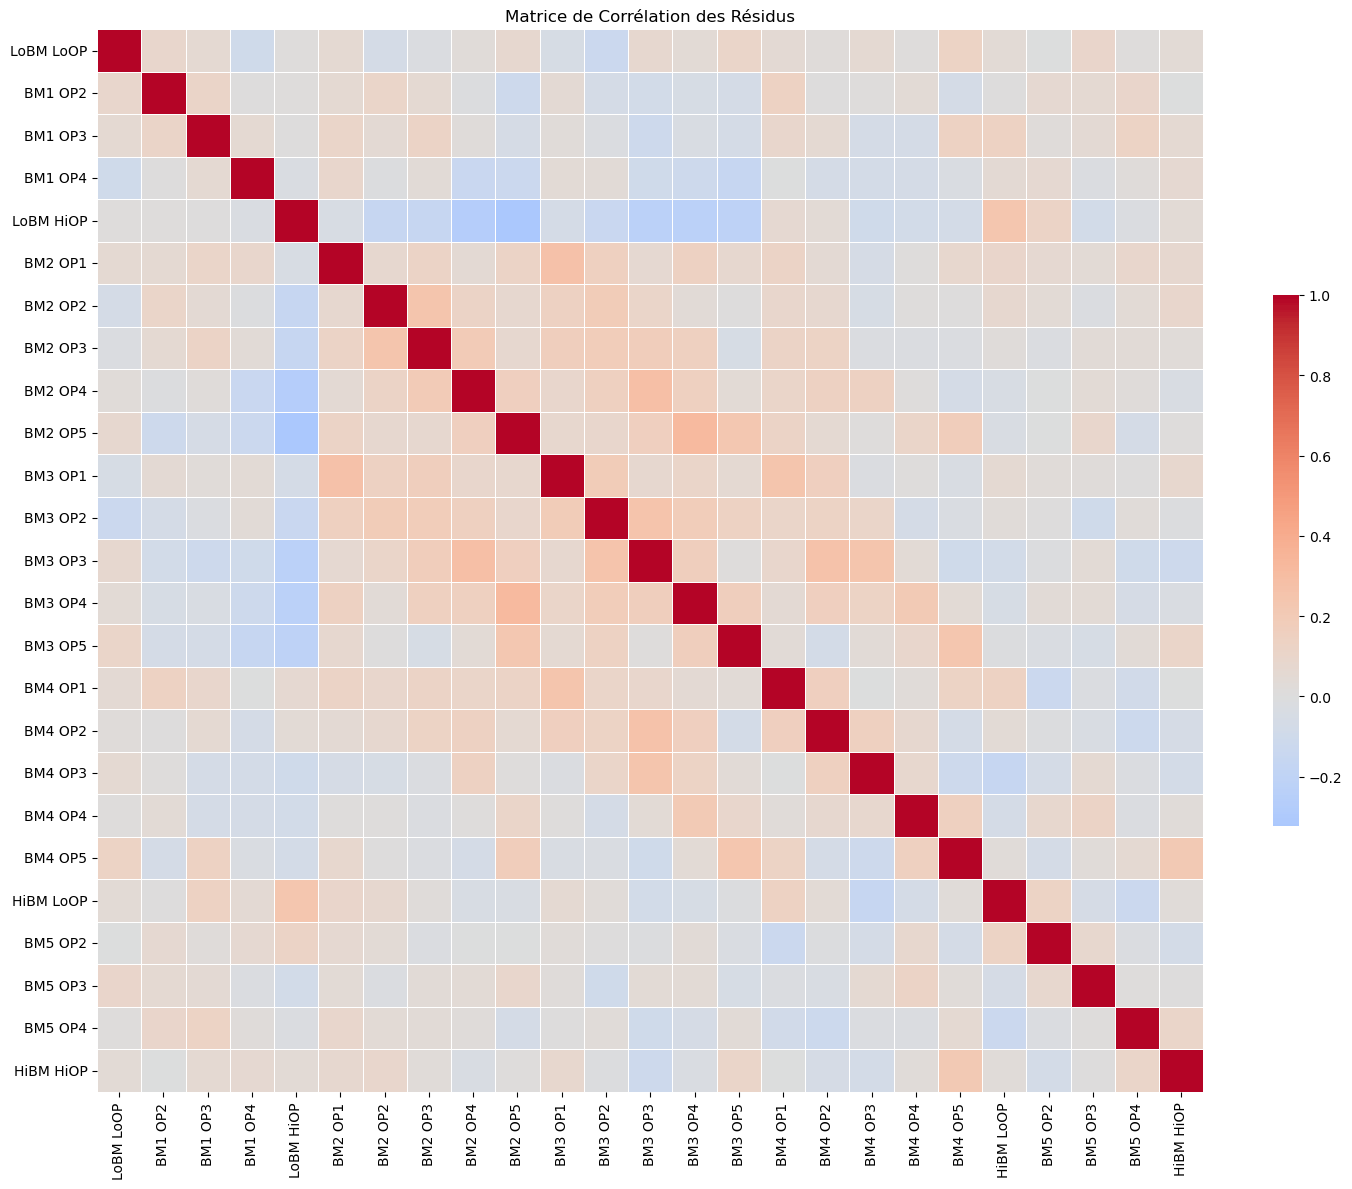

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Création d'un DataFrame pour stocker les résidus
residus = pd.DataFrame(index=excess_returns.index)

# Extraction des résidus pour chaque actif du modèle à 5 facteurs
for actif in excess_returns.columns:
    residus[actif] = resultats_5_facteurs[actif]['residus']

# Calcul de la matrice de corrélation des résidus
correlation_residus = residus.corr()

plt.figure(figsize=(15, 12))  # Ajustez la taille selon vos besoins
sns.heatmap(correlation_residus, cmap='coolwarm', center=0, cbar=True,
            linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Matrice de Corrélation des Résidus")
plt.xticks(rotation=90)  # Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité
plt.yticks(rotation=0)  # Rotation des étiquettes sur l'axe des y si nécessaire
plt.tight_layout()  # Ajuste automatiquement les sous-tracés pour qu'ils rentrent dans la figure
plt.show()


#### 4. Affichez et commentez les moyennes des $\vert \alpha_{i} \vert$

In [43]:
# Afficher les moyennes des |αi| pour chaque modèle
print(f"Moyenne des |α| pour le modèle de marché: {mean_alpha_market}")
print(f"Moyenne des |α| pour le modèle à 3 facteurs: {mean_alpha_3_facteurs}")
print(f"Moyenne des |α| pour le modèle à 5 facteurs: {mean_alpha_5_facteurs}")

# Commentaire
if mean_alpha_market > 0.05:  
    print("La moyenne des |α| pour le modèle de marché est significativement différente de zéro, ce qui peut indiquer que le modèle ne capture pas tous les facteurs de risque systématiques.")
else:
    print("La moyenne des |α| pour le modèle de marché est proche de zéro, suggérant que le modèle de marché est assez bon pour expliquer les variations des rendements.")

# Répétez le raisonnement similaire pour les modèles à 3 et 5 facteurs


Moyenne des |α| pour le modèle de marché: 1.0364924959258675
Moyenne des |α| pour le modèle à 3 facteurs: 0.25710614387044606
Moyenne des |α| pour le modèle à 5 facteurs: 0.27128587508015767
La moyenne des |α| pour le modèle de marché est significativement différente de zéro, ce qui peut indiquer que le modèle ne capture pas tous les facteurs de risque systématiques.


# IV. GRS test (Gibbon, Ross and Shanken (1989)) of frontier efficiency

Le test GRS vérifient si les constantes des régressions des rendements sur les facteurs sont simultanément nulles. L'hypothèse nulle du test GRS est :
$$
H_{0} : \alpha_{i}=0, \forall i=1,...,N
$$

On note :
    
- $\hat{\alpha}= (\hat{\alpha}_{1},\hat{\alpha}_{2},...,\hat{\alpha}_{N} )'$ le vecteur colonne des N $\hat{\alpha}_{i}$
- $f_{t} = (f_{1t}, f_{2t},...,f_{kt})'$ le vecteur des *k* facteurs à la date *t*
- $\hat{e}_{t} = (\hat{e}_{1t},...,\hat{e}_{Nt})'$ le vecteur des N résidus à la date *t*
- $\bar{f} = \frac{1}{T}\sum_{t=1}^{T}f_{t}$ le vecteur des moyennes empiriques des facteurs
- $\hat{\Omega} = \frac{1}{T}\sum_{t=1}^{T}f_{t}f_{t}^{'} - \bar{f}\bar{f}^{'}$ la matrice de variance covariance des facteurs
- $\hat{\Sigma} = \frac{1}{T-k-1}\sum_{t=1}^{T}e_{t}e_{t}^{'} $
                                                       
La statistique du test de nullité simultanée des constantes est :

$$\hat{W}=\frac{T(T-N-k)}{N(T-k-1)}(1-\bar{f}^{'}\hat{\Omega}^{-1}\bar{f})\hat{\alpha}^{'}\hat{\Sigma}^{-1}\hat{\alpha}$$
                                    
Sous $H_{0}$ on a $\hat{W} \sim \mathcal{F}(N,T-N-k)$ 
                                    
#### 1. Programmation et éxecution du test
Construire une fonction effectuant le test GRS et appliquez-là aux différents ensembles de facteurs (1, puis 3 puis 5 facteurs)

In [58]:
import numpy as np
from numpy.linalg import inv
from scipy.stats import f

def test_GRS(alpha_hat, residus, facteurs, T):
    N = alpha_hat.shape[0]  # Nombre d'actifs
    k = facteurs.shape[1]  # Nombre de facteurs
    f_bar = facteurs.mean(axis=0)  # Vecteur des moyennes empiriques des facteurs
    Omega_hat = ((facteurs.T @ facteurs)/ T) - np.outer(f_bar, f_bar)  # Matrice de variance-covariance des facteurs
    Sigma_hat = (residus.T @ residus) / (T - k - 1)  # Matrice de variance-covariance des résidus

    # Statistique du test GRS
    W = (T*(T - N - k) )/ (N * (T - k - 1)) * (1 - f_bar.T @ inv(Omega_hat) @ f_bar) * alpha_hat.T @ inv(Sigma_hat) @ alpha_hat
    return W

# Calculer les alphas_hat et les résidus pour chaque modèle
alphas_hat_5_fact = np.array([resultats['alpha_mean_abs'] for resultats in resultats_5_facteurs.values()])
residus_5_fact = np.array([resultats['residus'] for resultats in resultats_5_facteurs.values()]).T
facteurs = ff_data_clean[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].values  

# Nombre total d'observations
T = facteurs.shape[0]

# Assurez-vous que la variable N est définie avant de calculer la statistique GRS
N = excess_returns.shape[1]  # Nombre d'actifs ou de portefeuilles

# k est le nombre de facteurs dans le modèle
k = facteurs.shape[1]


# Exécuter le test GRS après avoir défini N et k
W_stat = test_GRS(alphas_hat_5_fact, residus_5_fact, facteurs, T)
print("Statistique du test GRS (5 facteurs):", W_stat)

# Calculer la valeur p pour la statistique F
p_value = 1 - f.cdf(W_stat, N, T - N - k)
print("P-value du test GRS (5 facteurs):", p_value)


Statistique du test GRS (5 facteurs): 8.12836867738971
P-value du test GRS (5 facteurs): 1.1102230246251565e-16


In [57]:
# Préparation des données pour un facteur (Mkt-RF)
mkt = ff_data_clean['Mkt-RF'].values
alphas_hat_market = np.array([resultats['alpha_mean_abs'] for resultats in resultats_market.values()])
residus_market = np.array([resultats['residus'] for resultats in resultats_market.values()]).T

# Calcul de la statistique du test GRS et de la p-value pour le modèle à un facteur
k_market = 1  # Un seul facteur
W_stat_market = test_GRS(alphas_hat_market, residus_market, mkt.reshape(-1, 1), T)
p_value_market = 1 - f.cdf(W_stat_market, N, T - N - k_market)
print("Statistique du test GRS pour un facteur:", W_stat_market)
print("P-value du test GRS pour un facteur:", p_value_market)



Statistique du test GRS pour un facteur: 93.45754059727072
P-value du test GRS pour un facteur: 1.1102230246251565e-16


In [56]:
#Préparation des données pour trois facteurs :
three_factors = ff_data_clean[['Mkt-RF', 'SMB', 'HML']].values
alphas_hat_3_fact = np.array([resultats['alpha_mean_abs'] for resultats in resultats_3_facteurs.values()])
residus_3_fact = np.array([resultats['residus'] for resultats in resultats_3_facteurs.values()]).T


#Calcul de la statistique du test GRS et de la p-value :
W_stat_3_fact = test_GRS(alphas_hat_3_fact, residus_3_fact, three_factors, T)
print("Statistique du test GRS pour trois facteurs:", W_stat_3_fact)
p_value_3_fact = 1 - f.cdf(W_stat_3_fact, N, T - N - 3)
print("P-value du test GRS pour trois facteurs:", p_value_3_fact)


Statistique du test GRS pour trois facteurs: 7.081562206810953
P-value du test GRS pour trois facteurs: 1.1102230246251565e-16


#### 2. Commentaires des résultats des tests
Indiquez les réponses du test pour chacun des trois ensembles de facteurs. Existe-t-il un ensemble de facteurs pour lequel les $\alpha_{i}$ sont tous simultanément égaux à 0 ?